# PART 1
Create a dataframe with node information
* Nodes would be based on unique start and end locations. Think about what you need to create a node dataframe.
* For Citi Bike data, you can easily use station information - already standardized.

LAB07 :-)

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import geopandas as gpd # GeoPandas library for spatial analytics
from shapely.geometry import shape
from shapely.geometry import Point 

from urllib.parse import urlencode
import urllib.request, json 

import networkx as nx #library supporting networks

import matplotlib.pyplot as plt
import seaborn as sns # visualization styling package
%matplotlib inline 

import requests
import json

In [3]:
citibike = pd.read_csv ('../nfh2118/data/202012-citibike-tripdata.csv')
citibike.head(3)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,694,2020-12-01 00:00:03.7770,2020-12-01 00:11:38.3160,4065,Wadsworth Ave & W 179 St,40.848467,-73.936064,3959,Edgecombe Ave & W 145 St,40.823498,-73.943860,49454,Customer,1988,2
1,4131,2020-12-01 00:00:09.1730,2020-12-01 01:09:00.2370,3284,E 88 St & Park Ave,40.781411,-73.955959,3147,E 85 St & 3 Ave,40.778012,-73.954071,49524,Subscriber,1988,1
2,1368,2020-12-01 00:00:28.7470,2020-12-01 00:23:16.9980,3443,W 52 St & 6 Ave,40.761330,-73.979820,3563,28 St & 36 Ave,40.757186,-73.932719,34312,Subscriber,1977,2


In [32]:
print(citibike.shape)
print(citibike.dtypes)

(1088929, 15)
tripduration                 int64
starttime                   object
stoptime                    object
start station id             int64
start station name          object
start station latitude     float64
start station longitude    float64
end station id               int64
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth year                   int64
gender                       int64
dtype: object


In [33]:
counts = citibike[['start station id','end station id']].nunique()
print(counts)

start station id    1174
end station id      1184
dtype: int64


As we can see from the statements above, there are 1,174 start stations and 1,184 end stations. Logically, these numbers should be matching with each other since one trip usually start from one single start station to another single end station. In the next part of analysis, we will be dropping such values that indicates invalid citibike trip.

### Converting dtype starttime and stoptime to datetime for descriptive analysis purposes
This part was reflected from previous Assignment 03 where we explored the characteristics of Citibike ridership during one month period. The codes represented here might be similar to the previous one, however, we used the December 2020 Citibike ridership data this time.

In [38]:
#drop rows that were less than 90 or more than 24 hours
citibike= citibike[~((citibike["tripduration"]<90) |(citibike["tripduration"]>86400))]

In [39]:
#drop rows that started and ended in the same station less than a 5 min
citibike= citibike[~((citibike["tripduration"]<=300) & (citibike["start station id"] == citibike["end station id"]))]

In [40]:
#convert dtype of column starttime
citibike['starttime'] = pd.to_datetime(citibike['starttime'],errors='coerce', format='%Y-%m-%d %H:%M:%S')

In [41]:
#convert dtype of column stoptime
citibike['stoptime'] = pd.to_datetime(citibike['stoptime'],errors='coerce', format='%Y-%m-%d %H:%M:%S')

In [42]:
#rides by hour and day
citibike['start hour']=citibike['starttime'].dt.hour.astype('category')
citibike['start day']=citibike['starttime'].dt.day.astype('category') 
citibike['weekday']=citibike['starttime'].dt.weekday.astype('category')

<AxesSubplot:xlabel='start hour', ylabel='count'>

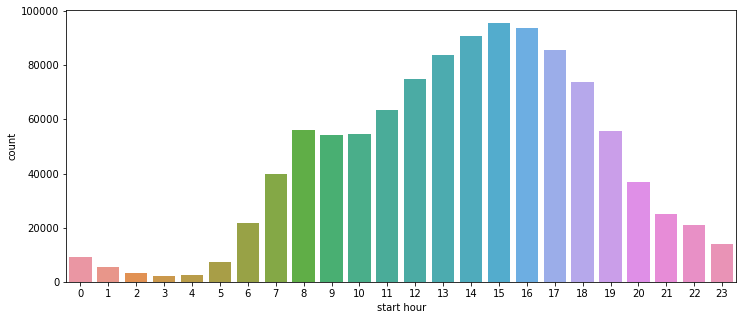

In [44]:
plt.figure(figsize=(12,5))
sns.countplot(data=citibike, x="start hour")

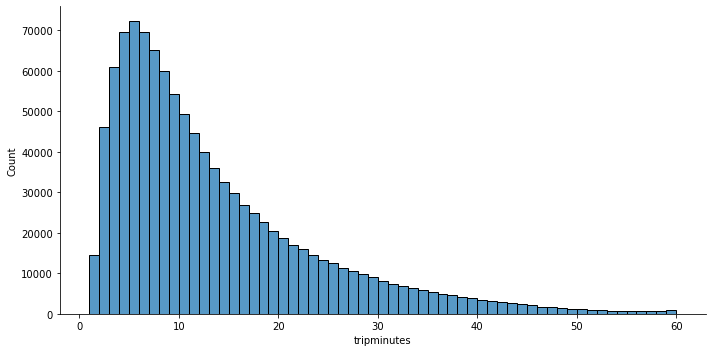

In [45]:
#trip duration in minutes
citibike['tripminutes'] = citibike['tripduration'] // 60
sns.displot(data=citibike,x="tripminutes", bins=range(1,61), aspect=10/5)

<AxesSubplot:xlabel='start day', ylabel='count'>

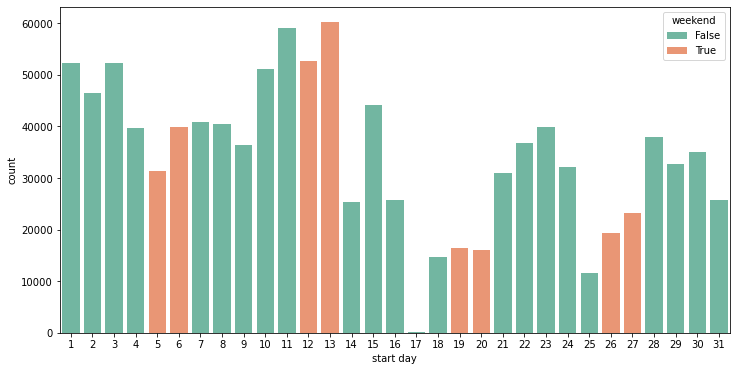

In [48]:
citibike['weekend'] = [d >= 5 for d in citibike['weekday']] # 0=monday
plt.figure(figsize=(12,6))
sns.set_palette('Set2')
sns.countplot(data=citibike, x = 'start day', hue='weekend', dodge=False)

Text(0.5, 1.0, 'Distribution of Citibike Riderships per Week')

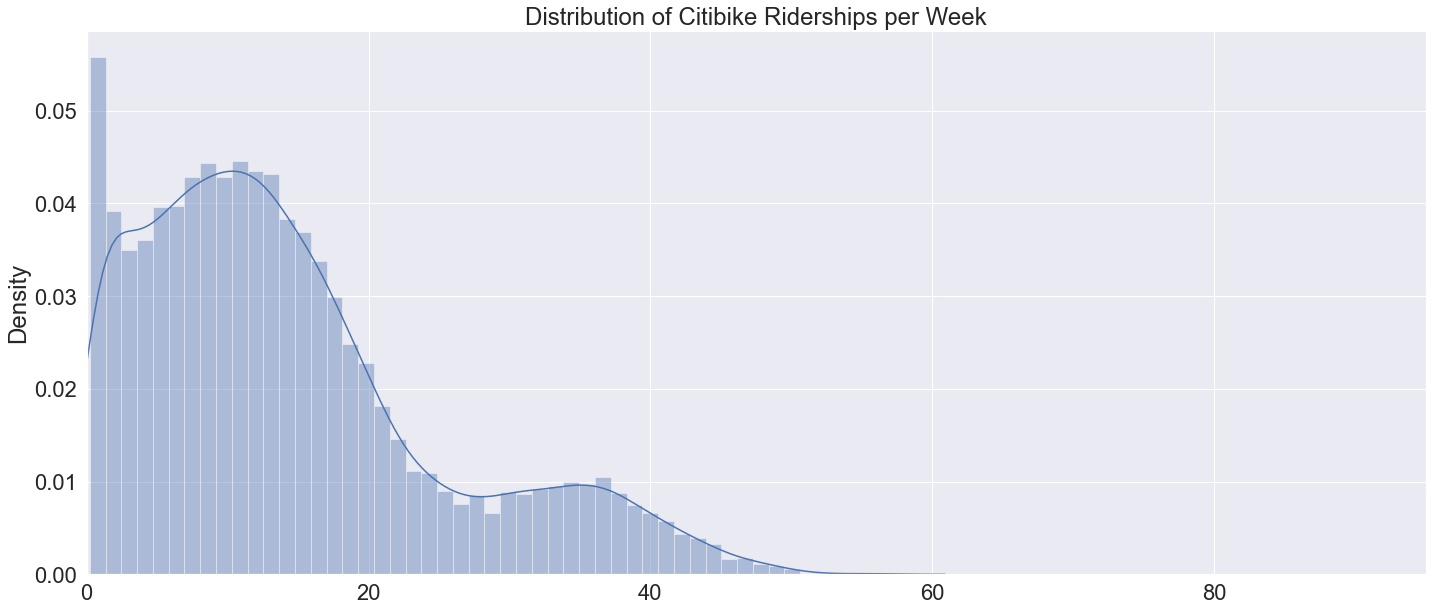

In [50]:
fig = plt.figure(figsize=(24, 10))
sns.set(font_scale=2)
ax = sns.distplot(np.array([len(citibike[citibike['bikeid'] == bike]) for bike in citibike['bikeid'].unique()]) / 31 * 7)
ax.set_xlim([0, 95])
ax.set_title("Distribution of Citibike Riderships per Week")

# PART 2
Create a dataframe with weighted edge (connection) information based on the data
Points.
* You need to group data by start and end locations.
* Weighted values mean the number of connections between start and end stations (e.g. 10 Citi Bike rides between station A and station B or 20 taxi rides between X and Y)

To create nodes, we need all stations id uniquely as an identity of bike stations related to December 2020 ridership. Firstly, we need to find every single start stations and end stations used in December 2020. Then, we drop duplicated start station (and save it as start_station) as well as for end station. Finally, we combine start station and end station. Since there might be some start station and end station that contain same value, we then drop values that are duplicated (lastly, save new version as all station).

In [2]:
citibike = pd.read_csv ('../nfh2118/data/202012-citibike-tripdata.csv')
citibike.head(3)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,694,2020-12-01 00:00:03.7770,2020-12-01 00:11:38.3160,4065,Wadsworth Ave & W 179 St,40.848467,-73.936064,3959,Edgecombe Ave & W 145 St,40.823498,-73.943860,49454,Customer,1988,2
1,4131,2020-12-01 00:00:09.1730,2020-12-01 01:09:00.2370,3284,E 88 St & Park Ave,40.781411,-73.955959,3147,E 85 St & 3 Ave,40.778012,-73.954071,49524,Subscriber,1988,1
2,1368,2020-12-01 00:00:28.7470,2020-12-01 00:23:16.9980,3443,W 52 St & 6 Ave,40.761330,-73.979820,3563,28 St & 36 Ave,40.757186,-73.932719,34312,Subscriber,1977,2


In [3]:
print(citibike.shape)
print(citibike.dtypes)

(1088929, 15)
tripduration                 int64
starttime                   object
stoptime                    object
start station id             int64
start station name          object
start station latitude     float64
start station longitude    float64
end station id               int64
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth year                   int64
gender                       int64
dtype: object


In [4]:
counts = citibike[['start station id','end station id']].nunique()
print(counts)

start station id    1174
end station id      1184
dtype: int64


In [13]:
citibike[citibike['end station id'] == 3536]

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
4226,1041,2020-12-01 07:36:01.3480,2020-12-01 07:53:23.2610,3992,W 169 St & Fort Washington Ave,40.842842,-73.942125,3536,W 116 St & Broadway,40.8082,-73.9641,48361,Subscriber,1969,0
6316,390,2020-12-01 08:14:44.0500,2020-12-01 08:21:14.2870,3629,Adam Clayton Powell Blvd & W 126 St,40.809495,-73.947765,3536,W 116 St & Broadway,40.8082,-73.9641,47710,Subscriber,1969,2
8645,912,2020-12-01 08:49:48.3010,2020-12-01 09:05:00.9930,3914,West End Ave & W 78 St,40.783786,-73.981687,3536,W 116 St & Broadway,40.8082,-73.9641,27316,Subscriber,1989,1
9099,564,2020-12-01 08:55:55.3220,2020-12-01 09:05:20.1390,3314,W 95 St & Broadway,40.793770,-73.971888,3536,W 116 St & Broadway,40.8082,-73.9641,46210,Subscriber,1959,1
11614,2043,2020-12-01 09:40:23.0450,2020-12-01 10:14:26.0980,435,W 21 St & 6 Ave,40.741740,-73.994156,3536,W 116 St & Broadway,40.8082,-73.9641,46037,Subscriber,1979,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1083928,63,2020-12-31 18:39:45.5100,2020-12-31 18:40:49.2930,3536,W 116 St & Broadway,40.808200,-73.964100,3536,W 116 St & Broadway,40.8082,-73.9641,36997,Subscriber,2001,1
1085518,153,2020-12-31 19:39:33.2290,2020-12-31 19:42:06.8880,3383,Cathedral Pkwy & Broadway,40.804213,-73.966991,3536,W 116 St & Broadway,40.8082,-73.9641,47576,Subscriber,1981,1
1087266,1542,2020-12-31 21:21:50.1660,2020-12-31 21:47:32.3050,530,11 Ave & W 59 St,40.771497,-73.990460,3536,W 116 St & Broadway,40.8082,-73.9641,47410,Subscriber,1965,1
1087760,969,2020-12-31 22:01:56.7510,2020-12-31 22:18:06.0910,3357,W 106 St & Amsterdam Ave,40.800836,-73.966449,3536,W 116 St & Broadway,40.8082,-73.9641,37598,Subscriber,1987,2


In [15]:
citibike[citibike['bikeid'] == 47576]

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
1649,756,2020-12-01 06:16:54.1620,2020-12-01 06:29:30.4600,161,LaGuardia Pl & W 3 St,40.729170,-73.998102,3735,W 30 St & 10 Ave,40.752694,-74.002353,47576,Subscriber,1990,1
2691,970,2020-12-01 06:55:43.9170,2020-12-01 07:11:53.9730,3735,W 30 St & 10 Ave,40.752694,-74.002353,151,Cleveland Pl & Spring St,40.722104,-73.997249,47576,Subscriber,1969,1
6845,317,2020-12-01 08:23:48.1050,2020-12-01 08:29:05.3060,151,Cleveland Pl & Spring St,40.722104,-73.997249,285,Broadway & E 14 St,40.734546,-73.990741,47576,Subscriber,1967,1
9244,1162,2020-12-01 08:58:20.7240,2020-12-01 09:17:43.2310,285,Broadway & E 14 St,40.734546,-73.990741,3436,Greenwich St & Hubert St,40.721319,-74.010065,47576,Customer,1969,0
43772,585,2020-12-01 18:28:11.3980,2020-12-01 18:37:57.3070,3436,Greenwich St & Hubert St,40.721319,-74.010065,3709,W 15 St & 6 Ave,40.738046,-73.996430,47576,Subscriber,1982,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080512,350,2020-12-31 17:00:44.8320,2020-12-31 17:06:35.3230,3533,St. Nicholas Ave & W 126 St,40.811432,-73.951878,3942,Broadway & W 133 St,40.819034,-73.956156,47576,Subscriber,1969,0
1082705,3112,2020-12-31 17:58:56.5920,2020-12-31 18:50:49.3020,3942,Broadway & W 133 St,40.819034,-73.956156,3383,Cathedral Pkwy & Broadway,40.804213,-73.966991,47576,Customer,1969,0
1085518,153,2020-12-31 19:39:33.2290,2020-12-31 19:42:06.8880,3383,Cathedral Pkwy & Broadway,40.804213,-73.966991,3536,W 116 St & Broadway,40.808200,-73.964100,47576,Subscriber,1981,1
1087595,675,2020-12-31 21:48:32.1090,2020-12-31 21:59:47.3180,3536,W 116 St & Broadway,40.808200,-73.964100,3999,Adam Clayton Powell Blvd & W 138 St,40.816960,-73.942296,47576,Subscriber,1965,1


In [34]:
# Return boolean denoting duplicate rows
citibike[['start station id', 'start station name', 'start station latitude', 'start station longitude', 'bikeid']].duplicated()

0          False
1          False
2          False
3          False
4          False
           ...  
1088924    False
1088925     True
1088926    False
1088927    False
1088928    False
Length: 1088929, dtype: bool

In [35]:
print (len(citibike)) # the number of rows of the original data

1088929


In [36]:
start_station = citibike[['start station id', 'start station name', 'start station latitude', 'start station longitude', 'bikeid']].drop_duplicates()
print (len(start_station)) # the number of rows after dropping duplicates (in other words, now we have only unique values)

922721


In [91]:
start_station.to_csv('../Downloads/start_station.csv', header=True)

In [93]:
citibike = pd.read_csv ('../nfh2118/data/202012-citibike-tripdata.csv')

In [94]:
# Return boolean denoting duplicate rows
citibike[['end station id', 'end station name', 'end station latitude', 'end station longitude', 'bikeid']].duplicated()

0          False
1          False
2          False
3          False
4          False
           ...  
1088924    False
1088925     True
1088926    False
1088927    False
1088928     True
Length: 1088929, dtype: bool

In [95]:
end_station = citibike[['end station id', 'end station name', 'end station latitude', 'end station longitude', 'bikeid']].drop_duplicates()
print (len(end_station)) # the number of rows after dropping duplicates (in other words, now we have only unique values)

921914


In [97]:
end_station.to_csv('../Downloads/end_station.csv', header=True)

### Combine start station and end station to find "All Station"

In [6]:
all_station = pd.read_csv('../nfh2118/all_station.csv')
all_station.head()

,Unnamed: 0,station id,station name,station latitude,station longitude,bikeid
0,0,3959,Edgecombe Ave & W 145 St,40.823498,-73.943860,49454
1,1,3147,E 85 St & 3 Ave,40.778012,-73.954071,49524
2,2,3563,28 St & 36 Ave,40.757186,-73.932719,34312
3,3,3336,E 97 St & Madison Ave,40.787801,-73.953559,45491
4,4,3952,E 141 St & Jackson Ave,40.806896,-73.911837,16558


In [56]:
all_station[['station id', 'station name', 'station latitude', 'station longitude']].duplicated()

0          False
1          False
2          False
3          False
4          False
           ...  
1048569     True
1048570     True
1048571     True
1048572     True
1048573     True
Length: 1048574, dtype: bool

In [57]:
all_station = all_station[['station id', 'station name', 'station latitude', 'station longitude']].drop_duplicates()
print (len(all_station)) # the number of rows after dropping duplicates (in other words, now we have only unique values)

1184


In [58]:
all_station

,station id,station name,station latitude,station longitude
0,3959,Edgecombe Ave & W 145 St,40.823498,-73.943860
1,3147,E 85 St & 3 Ave,40.778012,-73.954071
2,3563,28 St & 36 Ave,40.757186,-73.932719
3,3336,E 97 St & Madison Ave,40.787801,-73.953559
4,3952,E 141 St & Jackson Ave,40.806896,-73.911837
...,...,...,...,...
856003,4184,Southern Blvd & E 174 St,40.836733,-73.887931
880121,4306,35 St & 23 Ave,40.773015,-73.911190
880935,4328,W 167 St & St. Nicholas Ave,40.840124,-73.939490
888084,4310,24 St & 38 Ave,40.756351,-73.936515


In [59]:
all_station[all_station['station name'] == '35 St & 23 Ave']

,station id,station name,station latitude,station longitude
880121,4306,35 St & 23 Ave,40.773015,-73.91119


In [60]:
all_station.to_csv('../Downloads/all_station_new.csv', header=True)

# PART 3
Create a directed graph (network) using nodes and edge.

In [4]:
station_all = pd.read_csv ('../Downloads/all_station_new.csv')
station_all.head()

,Unnamed: 0,station id,station name,station latitude,station longitude
0,0,3959,Edgecombe Ave & W 145 St,40.823498,-73.943860
1,1,3147,E 85 St & 3 Ave,40.778012,-73.954071
2,2,3563,28 St & 36 Ave,40.757186,-73.932719
3,3,3336,E 97 St & Madison Ave,40.787801,-73.953559
4,4,3952,E 141 St & Jackson Ave,40.806896,-73.911837


In [5]:
print(station_all.dtypes)

Unnamed: 0             int64
station id             int64
station name          object
station latitude     float64
station longitude    float64
dtype: object


In [6]:
#bike stations as nodes
bikes = nx.DiGraph()
bikes.add_nodes_from(station_all['station name'])

In [7]:
#make dictionary for bike docks of starting point
BikeDock = {}
for c in range (len(station_all)): 
    BikeDock[station_all['station name'][c]] = station_all['station longitude'][c], station_all['station latitude'][c]

In [8]:
BikeDock

{'Edgecombe Ave & W 145 St': (-73.94386, 40.823498),
 'E 85 St & 3 Ave': (-73.95407149, 40.77801203),
 '28 St & 36 Ave': (-73.932719, 40.757186),
 'E 97 St & Madison Ave': (-73.953559, 40.787801),
 'E 141 St & Jackson Ave': (-73.911837, 40.806896),
 'Newtown Ave & 23 St': (-73.9246145, 40.7713615),
 '21 St & 36 Ave': (-73.9362726, 40.7601853),
 '3 Ave & E 100 St': (-73.94728331, 40.7877214),
 'Avenue D & E 8 St': (-73.975767, 40.72387),
 'W 16 St & The High Line': (-74.00681753, 40.74334935),
 'S 4 St & Wythe Ave': (-73.96590294, 40.71285887),
 'Hamilton Pl & W 140 St': (-73.951346, 40.822756),
 'E 2 St & Avenue C': (-73.98085795, 40.7208736),
 'Henry St & Middagh St': (-73.991581, 40.7003),
 'Lexington Ave & E 26 St': (-73.983293, 40.741459),
 '5 Ave & E 29 St': (-73.98683077, 40.7451677),
 'E 160 St & Tinton Ave': (-73.903944, 40.820302),
 'E 81 St & 2 Ave': (-73.95427465, 40.77477945),
 'W 33 St & 7 Ave': (-73.99093085, 40.75019995),
 'Hope St & Union Ave': (-73.95141312, 40.7116735

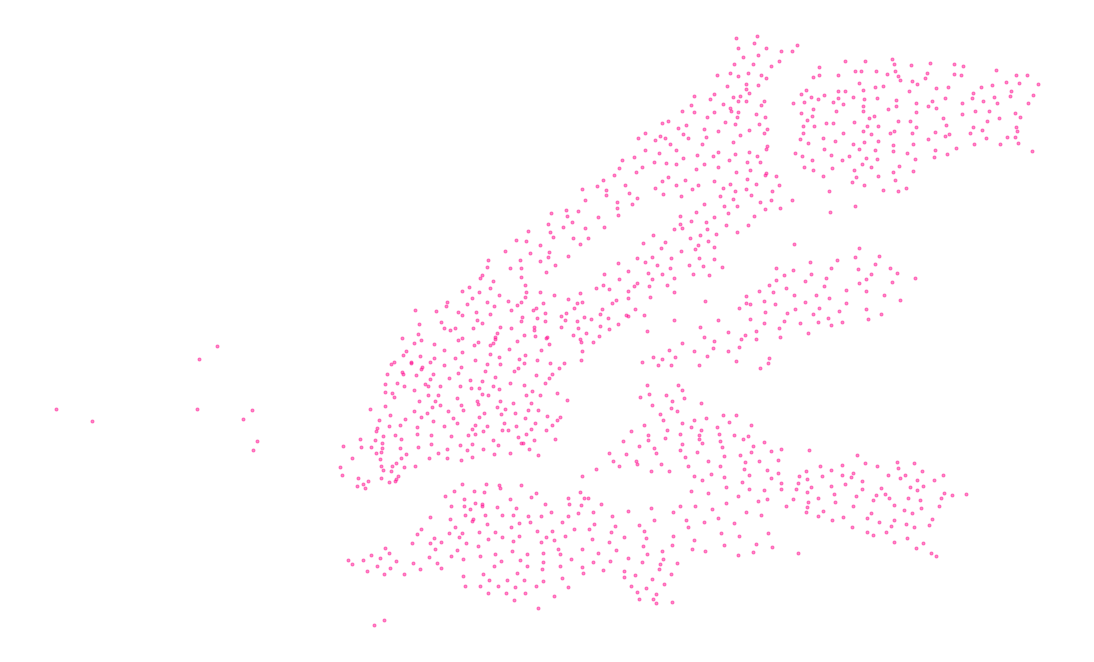

In [9]:
plt.figure(figsize = (15,9))
nx.draw(bikes, pos=BikeDock, with_labels = False, arrows=False, node_size=9,
       node_color='deeppink', alpha=0.5)

### Find the weighting value for each Citibike routes (in December 2020)

In [10]:
routes = citibike[['start station id', 'start station name', 'start station latitude', 'start station longitude', 'end station id', 'end station name', 'end station latitude', 'end station longitude','bikeid']]
routes.head()

,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid
0,4065,Wadsworth Ave & W 179 St,40.848467,-73.936064,3959,Edgecombe Ave & W 145 St,40.823498,-73.943860,49454
1,3284,E 88 St & Park Ave,40.781411,-73.955959,3147,E 85 St & 3 Ave,40.778012,-73.954071,49524
2,3443,W 52 St & 6 Ave,40.761330,-73.979820,3563,28 St & 36 Ave,40.757186,-73.932719,34312
3,72,W 52 St & 11 Ave,40.767272,-73.993929,3336,E 97 St & Madison Ave,40.787801,-73.953559,45491
4,3165,Central Park West & W 72 St,40.775794,-73.976206,3952,E 141 St & Jackson Ave,40.806896,-73.911837,16558


In [11]:
print (routes.drop_duplicates(['start station name','end station name']))
#total number of citibike routes made in December 2020: 214,076

         start station id           start station name  \
0                    4065     Wadsworth Ave & W 179 St   
1                    3284           E 88 St & Park Ave   
2                    3443              W 52 St & 6 Ave   
3                      72             W 52 St & 11 Ave   
4                    3165  Central Park West & W 72 St   
...                   ...                          ...   
1088828              3982        Bergen Ave & E 152 St   
1088832              3296              E 93 St & 2 Ave   
1088845              3429       Hanson Pl & Ashland Pl   
1088861              4044              8 Ave & W 38 St   
1088874              3711           E 13 St & Avenue A   

         start station latitude  start station longitude  end station id  \
0                     40.848467               -73.936064            3959   
1                     40.781411               -73.955959            3147   
2                     40.761330               -73.979820            3563   

In [14]:
routes = citibike[['start station id', 'start station name', 'start station latitude', 'start station longitude', 'end station id', 'end station name', 'end station latitude', 'end station longitude','bikeid']]

df = pd.DataFrame(routes, columns= ['start station name','end station name'])

dups_start_and_end = pd.pivot_table(data=df, columns=['start station name','end station name'], aggfunc='size')
print (dups_start_and_end)

start station name            end station name            
1 Ave & E 110 St              1 Ave & E 110 St                51
                              1 Ave & E 30 St                  1
                              1 Ave & E 62 St                  1
                              1 Ave & E 68 St                 10
                              1 Ave & E 78 St                  5
                                                              ..
Wythe Ave & Metropolitan Ave  Willoughby St & Ashland Pl       1
                              Willoughby St & Fleet St         6
                              Wilson Ave & Troutman St         1
                              Wyckoff St & Nevins St           1
                              Wythe Ave & Metropolitan Ave    64
Length: 214076, dtype: int64


In [66]:
print (dups_start_and_end[2])

1


In [67]:
print (dups_start_and_end.dtype)

int64


In [68]:
df2 = routes.groupby(['start station name','end station name']).count()
df2.head()

start station id  start station latitude  \
start station name end station name                                             
1 Ave & E 110 St   1 Ave & E 110 St                51                      51   
                   1 Ave & E 30 St                  1                       1   
                   1 Ave & E 62 St                  1                       1   
                   1 Ave & E 68 St                 10                      10   
                   1 Ave & E 78 St                  5                       5   

                                     start station longitude  end station id  \
start station name end station name                                            
1 Ave & E 110 St   1 Ave & E 110 St                       51              51   
                   1 Ave & E 30 St                         1               1   
                   1 Ave & E 62 St                         1               1   
                   1 Ave & E 68 St                        10              10   
                   1 Ave & E 78 St                         5               5   

                                     end station latitude  \
start station name end station name                         
1 Ave & E 110 St   1 Ave & E 110 St                    51   
                   1 Ave & E 30 St                      1   
                   1 Ave & E 62 St                      1   
                   1 Ave & E 68 St                     10   
                   1 Ave & E 78 St                      5   

                                     end station longitude  bikeid  
start station name end station name                                 
1 Ave & E 110 St   1 Ave & E 110 St                     51      51  
                   1 Ave & E 30 St                       1       1  
                   1 Ave & E 62 St                       1       1  
                   1 Ave & E 68 St                      10      10  
                   1 Ave & E 78 St                       5       5

In [69]:
print (df2.iloc[2])

start station id           1
start station latitude     1
start station longitude    1
end station id             1
end station latitude       1
end station longitude      1
bikeid                     1
Name: (1 Ave & E 110 St, 1 Ave & E 62 St), dtype: int64


In [70]:
df2.to_csv('../Downloads/routes.csv', header=True)

In [82]:
df3 = pd.read_csv ('../Downloads/routes.csv')
df3.head()

,start station name,end station name,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid
0,1 Ave & E 110 St,1 Ave & E 110 St,51,51,51,51,51,51,51
1,1 Ave & E 110 St,1 Ave & E 30 St,1,1,1,1,1,1,1
2,1 Ave & E 110 St,1 Ave & E 62 St,1,1,1,1,1,1,1
3,1 Ave & E 110 St,1 Ave & E 68 St,10,10,10,10,10,10,10
4,1 Ave & E 110 St,1 Ave & E 78 St,5,5,5,5,5,5,5


In [83]:
#rename column to 'number of routes'
df3.rename(columns = {'bikeid':'number of routes'}, inplace = True)
df3.head(2)

,start station name,end station name,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,number of routes
0,1 Ave & E 110 St,1 Ave & E 110 St,51,51,51,51,51,51,51
1,1 Ave & E 110 St,1 Ave & E 30 St,1,1,1,1,1,1,1


In [96]:
df3.drop(['start station id', 'start station latitude', 'start station longitude', 'end station id', 'end station latitude', 'end station longitude'], axis=1)

,start station name,end station name,number of routes
0,1 Ave & E 110 St,1 Ave & E 110 St,51
1,1 Ave & E 110 St,1 Ave & E 30 St,1
2,1 Ave & E 110 St,1 Ave & E 62 St,1
3,1 Ave & E 110 St,1 Ave & E 68 St,10
4,1 Ave & E 110 St,1 Ave & E 78 St,5
...,...,...,...
214071,Wythe Ave & Metropolitan Ave,Willoughby St & Ashland Pl,1
214072,Wythe Ave & Metropolitan Ave,Willoughby St & Fleet St,6
214073,Wythe Ave & Metropolitan Ave,Wilson Ave & Troutman St,1
214074,Wythe Ave & Metropolitan Ave,Wyckoff St & Nevins St,1


In [101]:
df3.head()

,start station name,end station name,number of routes
0,1 Ave & E 110 St,1 Ave & E 110 St,51
1,1 Ave & E 110 St,1 Ave & E 30 St,1
2,1 Ave & E 110 St,1 Ave & E 62 St,1
3,1 Ave & E 110 St,1 Ave & E 68 St,10
4,1 Ave & E 110 St,1 Ave & E 78 St,5


In [103]:
df3.to_csv ('../Downloads/routes_new.csv', header=True)

### Add Edges
Data Parsing for csv file used this part is in other notebook.

In [12]:
routes = pd.read_csv('../Downloads/final_routes.csv')
routes.head()

,OBJECTID,Field1,start_station_name,end_station_name,number_of_routes,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,route_id
0,1,1,1 Ave & E 110 St,1 Ave & E 30 St,1,3496,40.792327,-73.9383,536,40.741444,-73.975361,1.0
1,2,2,1 Ave & E 110 St,1 Ave & E 62 St,1,3496,40.792327,-73.9383,3142,40.761227,-73.960940,2.0
2,3,3,1 Ave & E 110 St,1 Ave & E 68 St,10,3496,40.792327,-73.9383,3141,40.765005,-73.958185,3.0
3,4,4,1 Ave & E 110 St,1 Ave & E 78 St,5,3496,40.792327,-73.9383,3140,40.771404,-73.953517,4.0
4,5,5,1 Ave & E 110 St,1 Ave & E 94 St,8,3496,40.792327,-73.9383,3312,40.781721,-73.945940,5.0


In [13]:
len(routes)

212928

In [14]:
#add edges
EN = len(routes.index)
edgelist = [0]*EN
#edgelist 

In [15]:
for j in range (0, EN):
    edgelist[j] = (routes['start_station_name'][j], routes ['end_station_name'][j], routes ['number_of_routes'][j])

In [16]:
edgelist

[('1 Ave & E 110 St', '1 Ave & E 30 St', 1),
 ('1 Ave & E 110 St', '1 Ave & E 62 St', 1),
 ('1 Ave & E 110 St', '1 Ave & E 68 St', 10),
 ('1 Ave & E 110 St', '1 Ave & E 78 St', 5),
 ('1 Ave & E 110 St', '1 Ave & E 94 St', 8),
 ('1 Ave & E 110 St', '11 Ave & W 59 St', 1),
 ('1 Ave & E 110 St', '12 Ave & W 40 St', 1),
 ('1 Ave & E 110 St', '2 Ave & E 104 St', 10),
 ('1 Ave & E 110 St', '2 Ave & E 122 St', 3),
 ('1 Ave & E 110 St', '2 Ave & E 125 St', 4),
 ('1 Ave & E 110 St', '2 Ave & E 31 St', 5),
 ('1 Ave & E 110 St', '2 Ave & E 72 St', 7),
 ('1 Ave & E 110 St', '2 Ave & E 96 St', 77),
 ('1 Ave & E 110 St', '2 Ave & E 99 St', 12),
 ('1 Ave & E 110 St', '3 Ave & E 112 St', 5),
 ('1 Ave & E 110 St', '3 Ave & E 62 St', 3),
 ('1 Ave & E 110 St', '3 Ave & E 71 St', 3),
 ('1 Ave & E 110 St', '5 Av & W 139 St', 2),
 ('1 Ave & E 110 St', '5 Ave & E 103 St', 10),
 ('1 Ave & E 110 St', '5 Ave & E 126 St', 3),
 ('1 Ave & E 110 St', '5 Ave & E 135 St', 5),
 ('1 Ave & E 110 St', '5 Ave & E 72 St', 

In [17]:
bikes.add_weighted_edges_from(edgelist)

# PART 4
* Calculate incoming and outgoing degrees of nodes and identify top 10 locations (stations) with the most incoming and outgoing rides. Please try to interpret your findings.

* Calculate at least two centrality measures and interpret the locations with the top 10 ranked centrality scores. If you are not familiar with geographic information, try to explore Google maps or any other maps to find any interesting characteristics around the areas with higher centrality scores.


In [18]:
print (bikes.in_degree())

[('Edgecombe Ave & W 145 St', 176), ('E 85 St & 3 Ave', 377), ('28 St & 36 Ave', 86), ('E 97 St & Madison Ave', 258), ('E 141 St & Jackson Ave', 25), ('Newtown Ave & 23 St', 130), ('21 St & 36 Ave', 56), ('3 Ave & E 100 St', 140), ('Avenue D & E 8 St', 186), ('W 16 St & The High Line', 315), ('S 4 St & Wythe Ave', 406), ('Hamilton Pl & W 140 St', 129), ('E 2 St & Avenue C', 278), ('Henry St & Middagh St', 156), ('Lexington Ave & E 26 St', 350), ('5 Ave & E 29 St', 366), ('E 160 St & Tinton Ave', 22), ('E 81 St & 2 Ave', 294), ('W 33 St & 7 Ave', 342), ('Hope St & Union Ave', 263), ('W 106 St & Central Park West', 248), ('2 Ave & E 125 St', 166), ('Motorgate', 130), ('West End Ave & W 60 St', 328), ('W 59 St & 10 Ave', 313), ('N 6 St & Bedford Ave', 328), ('Norman St & Wyckoff Ave', 88), ('8 Ave & W 52 St', 366), ('E 27 St & 1 Ave', 405), ('34 Ave & 13 St', 49), ('E 118 St & Madison Ave', 177), ('Wilson Ave & Troutman St', 147), ('W 95 St & Broadway', 284), ('Monroe St & Tompkins Ave', 

In [19]:
print (bikes.out_degree())

[('Edgecombe Ave & W 145 St', 176), ('E 85 St & 3 Ave', 363), ('28 St & 36 Ave', 103), ('E 97 St & Madison Ave', 274), ('E 141 St & Jackson Ave', 27), ('Newtown Ave & 23 St', 114), ('21 St & 36 Ave', 65), ('3 Ave & E 100 St', 127), ('Avenue D & E 8 St', 212), ('W 16 St & The High Line', 293), ('S 4 St & Wythe Ave', 376), ('Hamilton Pl & W 140 St', 131), ('E 2 St & Avenue C', 290), ('Henry St & Middagh St', 140), ('Lexington Ave & E 26 St', 339), ('5 Ave & E 29 St', 354), ('E 160 St & Tinton Ave', 25), ('E 81 St & 2 Ave', 308), ('W 33 St & 7 Ave', 371), ('Hope St & Union Ave', 252), ('W 106 St & Central Park West', 262), ('2 Ave & E 125 St', 155), ('Motorgate', 129), ('West End Ave & W 60 St', 362), ('W 59 St & 10 Ave', 346), ('N 6 St & Bedford Ave', 288), ('Norman St & Wyckoff Ave', 92), ('8 Ave & W 52 St', 385), ('E 27 St & 1 Ave', 391), ('34 Ave & 13 St', 61), ('E 118 St & Madison Ave', 179), ('Wilson Ave & Troutman St', 131), ('W 95 St & Broadway', 297), ('Monroe St & Tompkins Ave',

In [20]:
#To look specific station in & out degree
print (bikes.in_degree(weight='weight')['1 Ave & E 110 St'])
print (bikes.out_degree(weight='weight')['E 39 St & Lexington Ave'])

925
2671


In [21]:
in_degree = pd.DataFrame.from_dict(dict(bikes.in_degree()), orient='index').reset_index()
in_degree.columns = ['station name', 'in_degree']
in_degree.head(10)

,station name,in_degree
0,Edgecombe Ave & W 145 St,176
1,E 85 St & 3 Ave,377
2,28 St & 36 Ave,86
3,E 97 St & Madison Ave,258
4,E 141 St & Jackson Ave,25
5,Newtown Ave & 23 St,130
6,21 St & 36 Ave,56
7,3 Ave & E 100 St,140
8,Avenue D & E 8 St,186
9,W 16 St & The High Line,315


In [22]:
out_degree = pd.DataFrame.from_dict(dict(bikes.in_degree()), orient='index').reset_index()
out_degree.columns = ['station name', 'out_degree']
out_degree.head(10)

,station name,out_degree
0,Edgecombe Ave & W 145 St,176
1,E 85 St & 3 Ave,377
2,28 St & 36 Ave,86
3,E 97 St & Madison Ave,258
4,E 141 St & Jackson Ave,25
5,Newtown Ave & 23 St,130
6,21 St & 36 Ave,56
7,3 Ave & E 100 St,140
8,Avenue D & E 8 St,186
9,W 16 St & The High Line,315


In [23]:
in_out_degree = pd.merge(in_degree, out_degree, how='outer', on='station name')

In [24]:
in_out_degree.sort_values(by='in_degree', ascending=False).head(10)

,station name,in_degree,out_degree
193,1 Ave & E 68 St,556,556
204,E 17 St & Broadway,530,530
726,Cleveland Pl & Spring St,490,490
471,1 Ave & E 62 St,475,475
372,S 5 Pl & S 5 St,470,470
605,Lafayette St & Jersey St,465,465
286,Grand St & Elizabeth St,463,463
358,Forsyth St & Canal St,448,448
749,Mott St & Prince St,442,442
43,E 33 St & 1 Ave,438,438


## Degree Centrality
Calculate at least two centrality measures and interpret the locations with the top 10 ranked centrality scores. If you are not familiar with geographic information, try to explore Google maps or any other maps to find any interesting characteristics around the areas with higher centrality scores.

In [25]:
in_out_degree['sum_degree'] = in_out_degree['in_degree'] + in_out_degree['out_degree']

In [26]:
in_out_degree.sort_values(by='sum_degree', ascending=False).head(10)

,station name,in_degree,out_degree,sum_degree
193,1 Ave & E 68 St,556,556,1112
204,E 17 St & Broadway,530,530,1060
726,Cleveland Pl & Spring St,490,490,980
471,1 Ave & E 62 St,475,475,950
372,S 5 Pl & S 5 St,470,470,940
605,Lafayette St & Jersey St,465,465,930
286,Grand St & Elizabeth St,463,463,926
358,Forsyth St & Canal St,448,448,896
749,Mott St & Prince St,442,442,884
43,E 33 St & 1 Ave,438,438,876


In [27]:
print (in_out_degree['sum_degree'].mean())

359.6756756756757


In [28]:
#from lab
#output top ten centrality scores, given the dictionary d
def topdict(d,tn):
#     ind=sorted(d, key=dict(d).get, reverse=True)
    ind = sorted(dict(c1), key=dict(c1).__getitem__, reverse=True)
    for i in range(0,tn):
        print('{0}|{1}:{2}'.format(i+1,ind[i],d[ind[i]]))

In [29]:
c1 = nx.degree(bikes) #degree centrality calculation
topdict(c1, 10)

1|1 Ave & E 68 St:1107
2|E 17 St & Broadway:1023
3|1 Ave & E 62 St:949
4|Cleveland Pl & Spring St:943
5|S 5 Pl & S 5 St:936
6|Grand St & Elizabeth St:896
7|Lafayette St & Jersey St:896
8|Pershing Square North:868
9|Broadway & E 14 St:868
10|Broadway & E 22 St:863


In [30]:
c1 #all degree of centrality of all airports

DiDegreeView({'Edgecombe Ave & W 145 St': 352, 'E 85 St & 3 Ave': 740, '28 St & 36 Ave': 189, 'E 97 St & Madison Ave': 532, 'E 141 St & Jackson Ave': 52, 'Newtown Ave & 23 St': 244, '21 St & 36 Ave': 121, '3 Ave & E 100 St': 267, 'Avenue D & E 8 St': 398, 'W 16 St & The High Line': 608, 'S 4 St & Wythe Ave': 782, 'Hamilton Pl & W 140 St': 260, 'E 2 St & Avenue C': 568, 'Henry St & Middagh St': 296, 'Lexington Ave & E 26 St': 689, '5 Ave & E 29 St': 720, 'E 160 St & Tinton Ave': 47, 'E 81 St & 2 Ave': 602, 'W 33 St & 7 Ave': 713, 'Hope St & Union Ave': 515, 'W 106 St & Central Park West': 510, '2 Ave & E 125 St': 321, 'Motorgate': 259, 'West End Ave & W 60 St': 690, 'W 59 St & 10 Ave': 659, 'N 6 St & Bedford Ave': 616, 'Norman St & Wyckoff Ave': 180, '8 Ave & W 52 St': 751, 'E 27 St & 1 Ave': 796, '34 Ave & 13 St': 110, 'E 118 St & Madison Ave': 356, 'Wilson Ave & Troutman St': 278, 'W 95 St & Broadway': 581, 'Monroe St & Tompkins Ave': 427, 'Tompkins Ave & Hopkins St': 310, 'Willoughby

In [31]:
#eigen centrality
c2 = nx.eigenvector_centrality(bikes)
topdict(c2, 20)
#London is the most influential airport in the world

1|1 Ave & E 68 St:0.06870717647142487
2|E 17 St & Broadway:0.07229282894659379
3|1 Ave & E 62 St:0.062029575973039416
4|Cleveland Pl & Spring St:0.06555922282415111
5|S 5 Pl & S 5 St:0.052956876327557516
6|Grand St & Elizabeth St:0.06415532925739945
7|Lafayette St & Jersey St:0.06449816662555158
8|Pershing Square North:0.063385519247582
9|Broadway & E 14 St:0.0637377609080905
10|Broadway & E 22 St:0.0651205335259682
11|Forsyth St & Canal St:0.05731213270779327
12|Mott St & Prince St:0.060815865125914706
13|Broadway & W 25 St:0.0646029501155572
14|E 33 St & 1 Ave:0.06385811867831284
15|W 21 St & 6 Ave:0.0636790396829426
16|1 Ave & E 39 St:0.0625843209642628
17|E 58 St & 3 Ave:0.05814029056719979
18|Kent Ave & N 7 St:0.039114530155127995
19|2 Ave & E 31 St:0.06094522677592638
20|Broadway & W 60 St:0.05935632639689021


In [32]:
#betweenness centrality
c3 = nx.betweenness_centrality(bikes)
topdict(c3, 10)

1|1 Ave & E 68 St:0.015777382324831033
2|E 17 St & Broadway:0.0061703565356876515
3|1 Ave & E 62 St:0.008234674004881426
4|Cleveland Pl & Spring St:0.00510751629320981
5|S 5 Pl & S 5 St:0.006183911035204547
6|Grand St & Elizabeth St:0.0030572110860137944
7|Lafayette St & Jersey St:0.0029201257006280503
8|Pershing Square North:0.004036536383794745
9|Broadway & E 14 St:0.003907370103182151
10|Broadway & E 22 St:0.003277258369113875


In [33]:
#closeness centrality
c4 = nx.closeness_centrality(bikes)
topdict(c4, 10)

1|1 Ave & E 68 St:0.6457992953102507
2|E 17 St & Broadway:0.6300566255979207
3|1 Ave & E 62 St:0.6150632103933166
4|Cleveland Pl & Spring St:0.6070378553516501
5|S 5 Pl & S 5 St:0.5961478887000315
6|Grand St & Elizabeth St:0.599219232794313
7|Lafayette St & Jersey St:0.599219232794313
8|Pershing Square North:0.5982945117560502
9|Broadway & E 14 St:0.599219232794313
10|Broadway & E 22 St:0.5943201486222593


# PART 5
Visualize your network

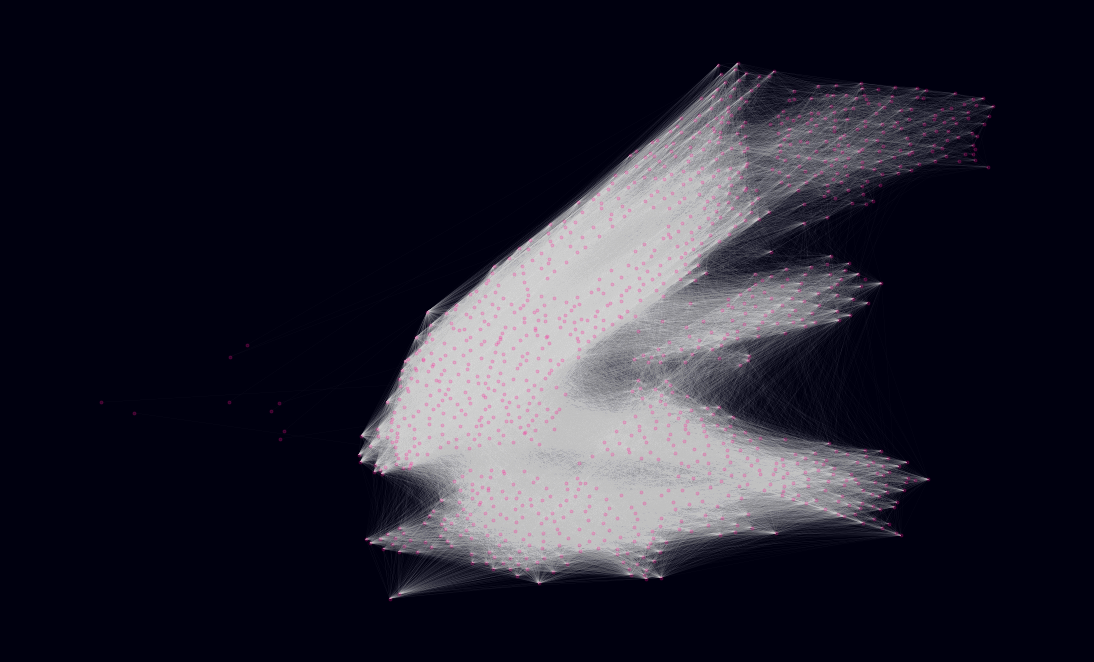

In [30]:
fig = plt.figure(figsize = (15,9))
nx.draw(bikes, pos=BikeDock, with_labels=False, arrows=False, node_size=9,
        node_color='deeppink', alpha=0.2, style='dotted', edge_color='white', width=0.2)
fig.set_facecolor("#00000F")

In [36]:
node_size_original = list(dict(c1).values()) # based on degree centrality(c1)
node_size_original

[352,
 740,
 189,
 532,
 52,
 244,
 121,
 267,
 398,
 608,
 782,
 260,
 568,
 296,
 689,
 720,
 47,
 602,
 713,
 515,
 510,
 321,
 259,
 690,
 659,
 616,
 180,
 751,
 796,
 110,
 356,
 278,
 581,
 427,
 310,
 219,
 691,
 797,
 753,
 673,
 513,
 523,
 720,
 847,
 411,
 473,
 345,
 444,
 74,
 680,
 706,
 606,
 268,
 237,
 477,
 762,
 835,
 421,
 471,
 701,
 363,
 509,
 637,
 307,
 689,
 714,
 337,
 271,
 580,
 687,
 370,
 731,
 342,
 613,
 742,
 407,
 313,
 476,
 634,
 431,
 763,
 489,
 488,
 282,
 599,
 660,
 301,
 210,
 564,
 242,
 107,
 341,
 797,
 495,
 655,
 532,
 415,
 672,
 616,
 604,
 515,
 294,
 287,
 753,
 503,
 686,
 821,
 115,
 531,
 733,
 672,
 197,
 330,
 522,
 282,
 563,
 671,
 743,
 227,
 526,
 525,
 579,
 686,
 639,
 87,
 460,
 197,
 593,
 709,
 481,
 615,
 650,
 529,
 366,
 707,
 85,
 640,
 529,
 454,
 232,
 155,
 398,
 704,
 298,
 255,
 504,
 619,
 419,
 256,
 359,
 530,
 187,
 868,
 201,
 167,
 632,
 726,
 700,
 209,
 560,
 716,
 80,
 623,
 106,
 279,
 305,
 827,
 682

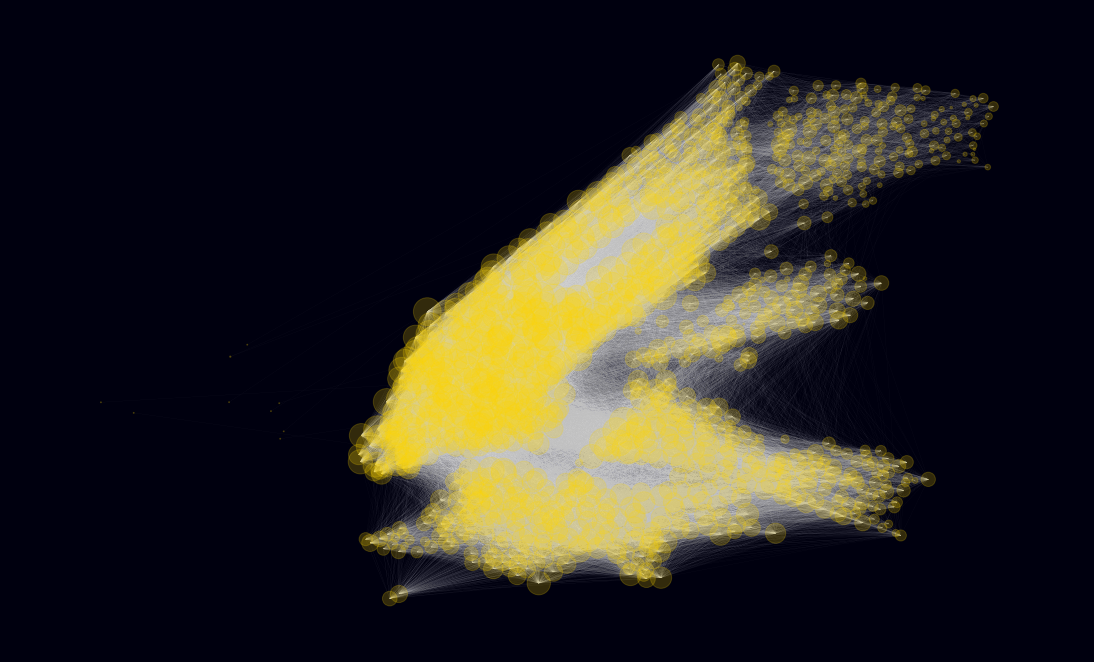

In [166]:
#visualize the network
fig = plt.figure(figsize = (15,9))
nx.draw(bikes, pos=BikeDock, with_labels=False,arrows=False, 
        node_size=node_size_original, 
       node_color='gold', alpha=0.2, style='dotted', edge_color='white', width=0.2)
fig.set_facecolor("#00000F")

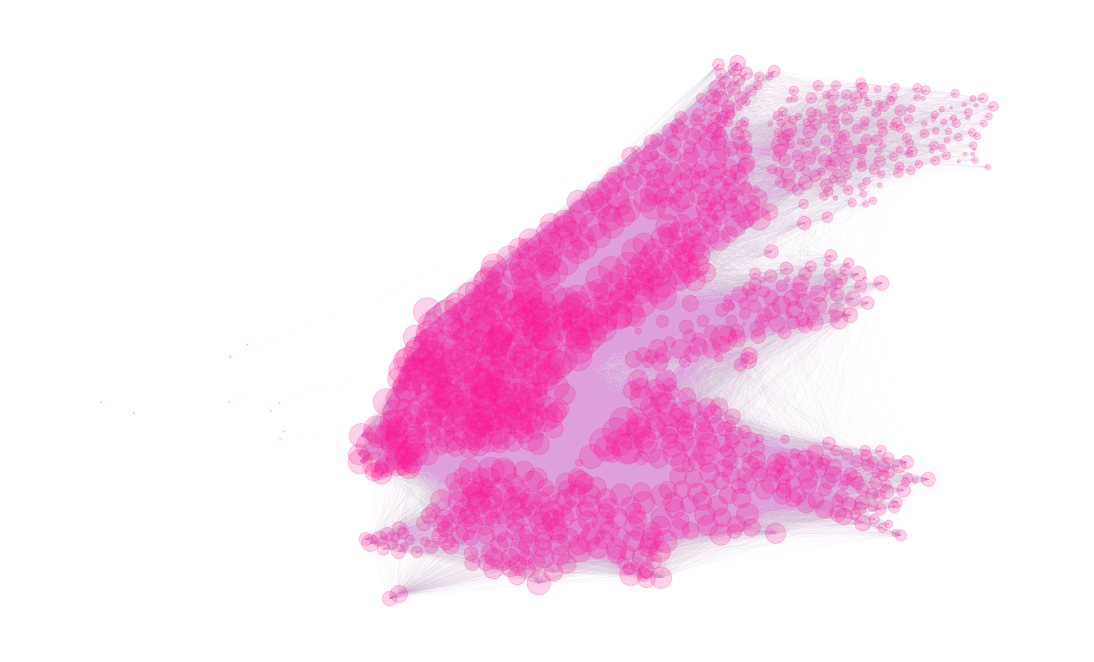

In [39]:
#visualize the network
fig = plt.figure(figsize = (15,9))
nx.draw(bikes, pos=BikeDock, with_labels=False,arrows=False, 
        node_size=node_size_original, 
        node_color='deeppink', alpha=0.2, style='dotted', edge_color='plum', width=0.2)
fig.set_facecolor("#FFFFFF")